# Project 07: Logistic Regression & Probabilistic Predictions

### Introduction
1. Data source: https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction
2. Data description
    1. There are two datasets loaded, a training dataset and a testing dataset.
        1. The training dataset is implemented to build up a model, while the testing dataset is to validate the model built.
        2. Variable definition
            * id: unique ID for the customer
            * Gender: gender of the customer
            * Age: age of the customer
            * Driving_License: 0 = customer does not have DL, 1 = customer already has DL
            * Region_Code: unique code for the region of the customer
            * Previously_Insured: 1 = customer already has Vehicle Insurance, 0 = customer doesn't have Vehicle Insurance
            * Vehicle_Age: age of the Vehicle
            * Vehicle_Damage: 
                * 1 = customer got his/her vehicle damaged in the past, 
                * 0 = customer didn't get his/her vehicle damaged in the past
            * Annual_Premium: the amount customer needs to pay as premium in the year
            * Policy_Sales_Channel: anonymized code for the channel of outreaching to the customer i.e., Different Agents, Over Mail, Over Phone, In Person, etc.
            * Vintage: number of days customer has been associated with the company
            * Response:	1 = customer is interested, 0 = customer is not interested
    2. The training dataset contains a predictor, Response, the testing dataset, however, does not contain it.
3. Objective
    1. To build up a model that predict whether the policyholders (customers) from past year will also be interested in Vehicle Insurance provided by the company.
    2. To perform multiple logistic regression to predict the probability of a client's interested in Vehicle Insurance.

<a id='Table of Contents'></a>
### Table of Contents
1. Part 1
    1. Data Preparation & Simple EDA
    2. Fitting Logistic Regression Models
    3. Quantifying Logistic Regression Model Fit

2. Part 2
    4. Generating Probabilistic Predictions
    5. Visualizing Logistic Regression Models


## 1. Data Preparation & Simple EDA

In [1]:
# Set up the path for installing packages
.libPaths('C:/Users/james/anaconda3/envs/r-tutorial/Lib/R/library')

In [2]:
# install.packages('IRdisplay')

In [21]:
# Load packages
library(data.table)
library(magrittr)
library(dplyr)
library(tidyr) 
library(skimr)
library(ggplot2)
library(yardstick)
library(pscl)
library(MASS)
library(caret)
library(workflows)
library(plotly)
library(IRdisplay)

# Suppress warning messages
options(warn = -1)

# Turn on warning messages
# options(warn = 0)

In [4]:
# Set up the working directory
setwd('C:/Users/james/Desktop/Coding/Kaggle/Health Insurance')

# Inspect the workspace
dir()

# Import trainng & testing dataset train.csv with fread()
train_df <- fread("train.csv")
test_df <- fread("test.csv")

# Call head() on training dataset: train_df
head(train_df)

[1] "1.png"                 "data descriptions.txt" "submission.csv"       
[4] "test.csv"              "train.csv"

id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
1,Male,44,1,28,0,> 2 Years,Yes,40454,26,217,1
2,Male,76,1,3,0,1-2 Year,No,33536,26,183,0
3,Male,47,1,28,0,> 2 Years,Yes,38294,26,27,1
4,Male,21,1,11,1,< 1 Year,No,28619,152,203,0
5,Female,29,1,41,1,< 1 Year,No,27496,152,39,0
6,Female,24,1,33,0,< 1 Year,Yes,2630,160,176,0


In [5]:
# Quick EDA to take a look at the training dataset
skimr::skim(train_df)

-- Data Summary ------------------------
                           Values  
Name                       train_df
Number of rows             381109  
Number of columns          12      
_______________________            
Column type frequency:             
  character                3       
  numeric                  9       
________________________           
Group variables            None    

-- Variable type: character ----------------------------------------------------
# A tibble: 3 x 8
  skim_variable  n_missing complete_rate   min   max empty n_unique whitespace
* <chr>              <int>         <dbl> <int> <int> <int>    <int>      <int>
1 Gender                 0             1     4     6     0        2          0
2 Vehicle_Age            0             1     8     9     0        3          0
3 Vehicle_Damage         0             1     2     3     0        2          0

-- Variable type: numeric ------------------------------------------------------
# A tibble: 9 x 11
  s

## 2. Fitting Logistic Regression Models
### (1) Computing full logistic regression model

In [6]:
# Fit the model to the train_df without interaction
# and predictiors not considered important: id

mdl_full <- glm(Response ~ Gender + Age + Driving_License + Region_Code + Previously_Insured + 
                    Vehicle_Age + Vehicle_Damage + Policy_Sales_Channel + Annual_Premium + Vintage,
                    data = train_df,
                    family = "binomial")

In [7]:
# Summary results of the full model
round(summary(mdl_full)$coef, digits = 5)  # ex) 2e-16 = 2.0 * 10-16

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-4.06999,0.17033,-23.89542,0.00000
GenderMale,0.09069,0.01113,8.15015,0.00000
Age,-0.02535,0.00055,-46.44958,0.00000
Driving_License,1.21131,0.16343,7.41198,0.00000
Region_Code,-0.00037,0.00044,-0.84370,0.39884
Previously_Insured,-3.97282,0.08265,-48.06926,0.00000
Vehicle_Age> 2 Years,1.38133,0.02696,51.23876,0.00000
Vehicle_Age1-2 Year,1.17210,0.01880,62.34012,0.00000
Vehicle_DamageYes,2.02806,0.03427,59.18698,0.00000
Policy_Sales_Channel,-0.00244,0.00011,-22.30165,0.00000


#### Observations
1. Except for Vintage and Region_Code, all other variables are statistically significant predictors(p < 0.05).
2. All significant predictors, except for Age, Region_Code, Policy_Sales_Channel, Previously_Insured and Vintage, have a positive coefficient.

### (2) Computing stepwise logistic regression model

In [8]:
# Fit the model
mdl_step <- glm(Response ~ Gender + Age + Driving_License + Region_Code + Previously_Insured + 
                    Vehicle_Age + Vehicle_Damage + Policy_Sales_Channel + Annual_Premium + Vintage,
                    data = train_df,
                    family = "binomial") %>%
                    stepAIC(trace = FALSE)

# Summary results of the final selected model
summary(mdl_step)$coef

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-4.080521e+00,1.696599e-01,-24.051188,8.112272e-128
GenderMale,9.080387e-02,1.112682e-02,8.160813,3.327759e-16
Age,-2.535045e-02,5.456680e-04,-46.457644,0.000000e+00
Driving_License,1.210940e+00,1.634228e-01,7.409861,1.264318e-13
Previously_Insured,-3.972858e+00,8.264784e-02,-48.069709,0.000000e+00
Vehicle_Age> 2 Years,1.381141e+00,2.695760e-02,51.233843,0.000000e+00
Vehicle_Age1-2 Year,1.172021e+00,1.880127e-02,62.337339,0.000000e+00
Vehicle_DamageYes,2.027891e+00,3.426464e-02,59.183178,0.000000e+00
Policy_Sales_Channel,-2.439167e-03,1.094386e-04,-22.287990,4.832077e-110
Annual_Premium,2.574046e-06,2.956401e-07,8.706688,3.128833e-18


#### Observations
As I expected, the function chose a final model in which two variables, Region_Code and Vintage, have been removed from the original full model.


## 3. Quantifying Logistic Regression Model Fit
1. In this chapter, I will:
    1. compare the full logistic regression model with the stepwise logistic regression model with model performance metrics.
    2. arbitrarily narrow down the predictors by comparing their contribution to the residual deviance reduction.


### (1) Comparing full vs stepwise model with Prediction Accuracy
1. I will compare the performance of the full and stepwise logistic model.
2. The best model is defined as the model that has the lowest classification error rate in predicting the class of new test data.
3. Let's compare the prediction accuracy of each model.


#### (a) Full model

In [9]:
# Fit the model
mdl_full <- glm(Response ~ Gender + Age + Driving_License + Region_Code + Previously_Insured + 
                    Vehicle_Age + Vehicle_Damage + Policy_Sales_Channel + Annual_Premium + Vintage,
                    data = train_df,
                    family = "binomial")

# Obtain the actual client's responses and predicted responses by the model
actual_response <- train_df$Response
predicted_response <- round(fitted(mdl_full))

# Tabulate both responses
outcomes <- table(predicted_response, actual_response)
outcomes

                  actual_response
predicted_response      0      1
                 0 334388  46704
                 1     11      6

In [10]:
# Convert the table into a yardstick confusion matrix object using conf_mat()
confusion <- conf_mat(outcomes)

# Gain the major model performance metrics
summary(confusion, event_level = "second")[1:4, ]

.metric,.estimator,.estimate
accuracy,binary,0.8774235193
kap,binary,0.0001676449
sens,binary,0.0001284522
spec,binary,0.9999671052


#### (b) Stepwise model

In [11]:
# Fit the model
mdl_step <- glm(Response ~ Gender + Age + Driving_License + Previously_Insured + 
                    Vehicle_Age + Vehicle_Damage + Policy_Sales_Channel + Annual_Premium,
                    data = train_df,
                    family = "binomial")

# Obtain the actual client's responses and predicted responses by the model
actual_response <- train_df$Response
predicted_response <- round(fitted(mdl_step))

# Tabulate both responses
outcomes <- table(predicted_response, actual_response)
outcomes

                  actual_response
predicted_response      0      1
                 0 334387  46703
                 1     12      7

In [12]:
# Convert the table into a yardstick confusion matrix object using conf_mat()
confusion <- conf_mat(outcomes)

# Gain the major model performance metrics
summary(confusion, event_level = "second")[1:4, ]

.metric,.estimator,.estimate
accuracy,binary,0.8774235193
kap,binary,0.0001999513
sens,binary,0.0001498608
spec,binary,0.9999641147


#### Observations

1. First of all, both models have the identical prediction accuracy value of 0.87742, meaning there is no difference in predicting outcomes between these two models.
2. To interpret the confusion matrix derived from the step model c, for example, we should pay attention to two numbers, 334387 and 7, which determine the model's prediction accuracy. 
    * It means that the stepwise model predicted correctly that 334387 clients are not interested and 7 clients are interested.
    * There are 46703 false negatives and 12 false positives.
    * Prediction accuray is computed as follows: 
        * Dividing the sum of 334387, TN; True Negative and 7, TP; True Positive by the total number of clients 381109.
        * 334387 / 381109 = 0.8774

### (2) With k-fold Cross Validation
#### (a) Full model

In [13]:
# Define training control
train_control <- trainControl(method = "cv", number = 10)  

# Train the model on training set
mdl_full_cv <- train(Response ~ .,
                       data = train_df,
                       trControl = train_control,
                       method = "glm",
                       family = binomial()
                       )

# Print cv scores
mdl_full_cv$results

Warning message in train.default(x, y, weights = w, ...):
"You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column."

parameter,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
none,0.2995545,0.165583,0.179514,0.001605387,0.003833521,0.001329068


#### (b) Stepwise model

In [14]:
# Define training control
train_control <- trainControl(method = "cv", number = 10)

# Train the model on training set
mdl_step_cv <- train(Response ~ Gender + Age + Driving_License + Previously_Insured + 
                       Vehicle_Age + Vehicle_Damage + Policy_Sales_Channel + Annual_Premium,
                       data = train_df,
                       trControl = train_control,
                       method = "glm",
                       family = binomial()
                       )

# Print cv scores
mdl_step_cv$results

Warning message in train.default(x, y, weights = w, ...):
"You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column."

parameter,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
none,0.299552,0.1656299,0.1795127,0.001176911,0.003307528,0.001050904


#### Observations

1. Let's pay attention to the values of RMSE from both results. 
2. Root Mean Squared Error (RMSE), which measures the average prediction error made by the model in predicting the outcome for an observation. That is, the average difference between the observed known outcome values and the values predicted by the model. The lower the RMSE, the better the model.
3. As seen above, both models have almost an identical value of RMSE, meaning technically they do not have difference in terms of their performance in predicting outcomes.

### (3) Other model performance metrics
#### (a) McFadden's pseudo R-squared
1. McFadden's pseudo R-squared is sometimes referred to as a closer equivalent of the coefficient of determination, R-squared, in linear regressions.
2. McFadden's R-squared tend to be considerably lower than those of the R-squared index.
For example, values of 0.2 to 0.4 for McFadden's R-squared represent excellent model fit.

In [15]:
# Obtain McFadden's pseudo R-squared for the full model
round(pR2(mdl_full), digits = 4)

fitting null model for pseudo-r2


llh      llhNull           G2     McFadden         r2ML         r2CU 
-104750.9806 -141773.0765   74044.1917       0.2611       0.1766       0.3365

In [16]:
# Obtain McFadden's pseudo R-squared for the stepwise model
round(pR2(mdl_step), digits = 4)

fitting null model for pseudo-r2


llh      llhNull           G2     McFadden         r2ML         r2CU 
-104751.3425 -141773.0765   74043.4680       0.2611       0.1766       0.3365

#### Observations
As seen above, McFadden's index is about 0.26 for both models indicating that they are greatly fitted.


#### (b) Residual deviance reduction
Let's get the detailed table of deviance from the stepwise model

In [17]:
# Return a table of deviance
df <- anova(mdl_step, test = "Chisq")
df

# Extract the column: Residual Deviance
df1 <- subset(df, select = c("Resid. Dev"))
df1

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,381108,283546.2,NA
Gender,1,1058.14502,381107,282488.0,4.130355e-232
Age,1,4002.12514,381106,278485.9,0.000000e+00
Driving_License,1,143.97930,381105,278341.9,3.590187e-33
Previously_Insured,1,56009.88369,381104,222332.0,0.000000e+00
Vehicle_Age,2,5990.06873,381102,216342.0,0.000000e+00
Vehicle_Damage,1,6190.02350,381101,210151.9,0.000000e+00
Policy_Sales_Channel,1,573.91643,381100,209578.0,7.895742e-127
Annual_Premium,1,75.32623,381099,209502.7,3.990231e-18


,Resid. Dev
NULL,283546.2
Gender,282488.0
Age,278485.9
Driving_License,278341.9
Previously_Insured,222332.0
Vehicle_Age,216342.0
Vehicle_Damage,210151.9
Policy_Sales_Channel,209578.0
Annual_Premium,209502.7


In [18]:
# Loop over the rows to compute the difference in deviance between rows
for(i in 1:nrow(df1)) {
    diff_vars <- df1[i, ] - df1[i+1, ]
    
    if (i == 9) {
        break
    }
    print(round(diff_vars, digits = 2))
}

[1] 1058.15
[1] 4002.13
[1] 143.98
[1] 56009.88
[1] 5990.07
[1] 6190.02
[1] 573.92
[1] 75.33


In [19]:
# Create a dataframe that shows variables and its contribution to residual deviance reduction 
vars <- c("Gender", "Age", "Driving_License", "Previously_Insured", "Vehicle_Age",
                        " Vehicle_Damage", "Policy_Sales_Channel", "Annual_Premium")
resid_dev_reduced <- c(1058.15, 4002.13, 143.98, 56009.88, 5990.07, 6190.02, 573.92, 75.33)
diff_df <- data.frame(vars, resid_dev_reduced)
diff_df

vars,resid_dev_reduced
Gender,1058.15
Age,4002.13
Driving_License,143.98
Previously_Insured,56009.88
Vehicle_Age,5990.07
Vehicle_Damage,6190.02
Policy_Sales_Channel,573.92
Annual_Premium,75.33


In [20]:
# Plot the amount of residual deviance reduced by each variable with a barplot
p4 <- ggplot(diff_df, aes(resid_dev_reduced, vars, fill = vars)) +
        geom_bar(stat = 'identity', width = 0.8) +
        theme(axis.text.x = element_text(face = "bold"), axis.text.y = element_text(face = "bold")) +
        labs(x="Reduction in Residual Deviance", y="Predictors", title="Predictors Contribution to Reduction in Resid. Dev")

fig4 <- ggplotly(p4)
# fig4

# Save a plot as a html file
# htmlwidgets::saveWidget(fig4, "C:/Users/james/Desktop/Coding/Projects/fig4.html")

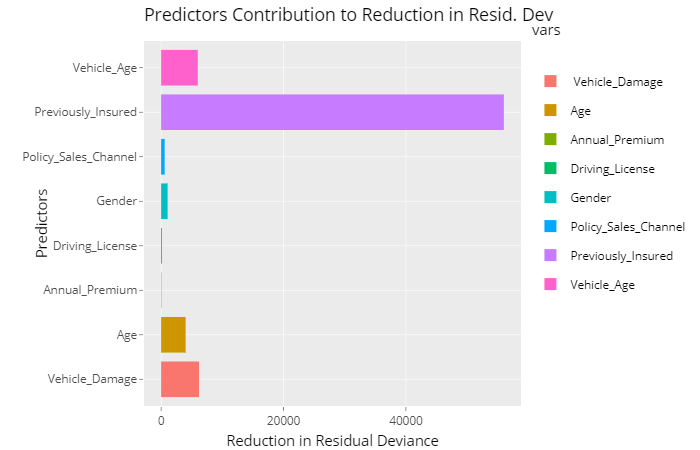

#### Observations
1. First, let's look at the difference between the null deviance, which is the deviance of the null model (i.e., a model with only an intercept), and the residual deviance.
2. The bigger the difference is, the better the model is doing against the null model.
3. I tabulated the residual deviance reduced by each variable and also plotted them in the bar plot for easy comparison.
4. As seen above, adding the ownership of vehicle insurance; Previously_Insured, alone reduces the residual deviance drastically.
5. On the other hand, the predictors whose residual deviance reduction is comparatively small, such as Policy_Sales_Channel, Gender, Driving_License, and Annual_Premium, indicate that these variables do not add much to the model.

### <a href='#Table of Contents'>[Move to Table of Contents]</a>